
## Understanding LangGraph

LangGraph is a special LangChain-built library that focuses on building intelligent AI Agents using graphs. Ie, agentic state machines.

We need these prerequisite libraries to run a graph visualization library (pygraphviz). We will use this library during this notebook to understand the structure of our graphs but it is not required to use langgraph



## Building a LangGraph Application

### Step 1: Define the StateGraph
Define a StateGraph object to structure the chatbot as a state machine. The State is a class object defined with a single key messages of type List and uses the add_messages() function to append new messages rather than overwrite them.
```
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    # messages have the type "list".
    # The add_messages function appends messages to the list, rather than overwriting them
    messages: Annotated[list, add_messages]
graph_builder = StateGraph(State)
```

### Step 2: Initialize an LLM and add it as a Chatbot node
Here, we initialize the AzureChatOpenAI model and create a simple chatbot function that takes in the state messages as input and generates a message response (which is subsequently appended to the state).

This chatbot function is added as a node named “chatbot” to the graph.
```
from langchain_openai import AzureChatOpenAI
llm = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
)
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}
‘’’The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used.’’’
graph_builder.add_node("chatbot", chatbot)
```
### Step 3: Set edges
Since we are building a simple chatbot, we set the chatbot node as both the entry and finish points of the graph to indicate where to start and end the process.
```
# Set entry and finish points
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
```

### Step 4: Compile and Visualize the Graph
Compile the graph to create a CompiledGraph object, and optionally, we can visualize the graph structure using the code below:
```
graph = graph_builder.compile()
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass
```
### Step 5: Run the chatbot
Finally, we implement a loop to continuously prompt the user for input, process it through the graph, and print the assistant's response. The loop exits when the user types "quit", "exit", or "q".
```
# Run the chatbot
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
```

## Advanced LangGraph Features

### Custom node types
LangGraph allows you to create custom node types to implement complex agent logic. This provides flexibility and control over your application's behavior.

```
from typing import Annotated
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class MyCustomNode:
    def __init__(self, llm):
        self.llm = llm
    def __call__(self, state):
        # Implement your custom logic here
        # Access the state and perform actions
        messages = state["messages"]
        response = self.llm.invoke(messages)
        return {"messages": [response]}
graph_builder = StateGraph(State)
llm = ChatAnthropic(model="claude-3-haiku-20240307")
custom_node = MyCustomNode(llm)
graph_builder.add_node("custom_node", custom_node)
```
Here, we define a class MyCustomNode that encapsulates custom logic and interacts with the LLM. This provides a more structured and maintainable way to implement complex node behaviors.

### Edge types
LangGraph supports different edge types to handle various communication patterns between nodes. One useful type is the conditional edge, which allows for decision-making based on a node's output.

To create a conditional edge, you need three components:

  1. The upstream node: The node's output decides the next step.  
  2. A function: This function evaluates the upstream node's output and determines the next node to execute, returning a string that represents the decision.  
  3. A mapping: This mapping links the possible outcomes of the function to the corresponding nodes to be executed.

Here's an example in pseudocode:
```
graph.add_conditional_edge(
    "model",
    should_continue,
    {
        "end": END,
        "continue": "tools"
    }
)
```
Here, after the “model” node is called, we can either exit the graph (”end”) and return to the user, or we can continue (”continue”) and call a tool—depending on what the user decides!

### state management
LangGraph offers powerful state management techniques, which include using external databases like SQLite, PostgreSQL, and MongoDB, or cloud storage solutions like Amazon S3, Google Cloud Storage, and Azure Blob Storage to store and retrieve your agent's state, enabling reliability and scalability.

Here's an example of using a SQLite database for state management:
```
from langgraph.checkpoint.sqlite import SqliteSaver

# Connect to the SQLite database
memory = SqliteSaver.from_conn_string(":memory:")

# Compile the graph with the checkpointer
graph = graph_builder.compile(checkpointer=memory)
```

### Error handling
LangGraph also provides mechanisms for error handling:

- Exceptions: Node functions can raise exceptions to signal errors during execution. You can catch and handle these exceptions to prevent your graph from crashing.

- Retry mechanisms: You can implement retry logic within your nodes to handle transient errors, such as network issues or API timeouts.

- Logging: Use logging to record errors and track the execution of your graph.


In [ ]:
!apt-get install python3-dev graphviz libgraphviz-dev pkg-config

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
python3-dev is already the newest version (3.10.6-1~22.04).
python3-dev set to manually installed.
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 45 not upgraded.
Need to get 2,481 kB of archives.
After this operation, 7,683 kB of additional dis

In [ ]:
!pip install -qU \
    langchain-openai==0.1.3 \
    langchain==0.1.16 \
    langchain-core==0.1.42 \
    langgraph==0.0.37 \
    langchainhub==0.1.15 \
    pygraphviz==1.12  # for visualizing

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Graph State
We will define a custom graph state to support our agent-oriented decision making. In this we will define:

- our user input (ie the most recent message from the user)  
- agent_out which is used by the graph (and our final output) to consume/output agent outputs  
- intermediate_steps which is a list maintained over our graph runtime to keep track of the results of previous steps

During each step in our graph we will be able to add to, modify, or extract these values from our state object.

In [ ]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
import operator

class AgentState(TypedDict):
    input: str
    agent_out: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

## Emulate Search
To test a RAG-like agent we'll provide a tool that provide information as we would expect a search tool in a RAG agent to do.

In [ ]:
ehi_information = """Title: EHI: End-to-end Learning of Hierarchical Index for
Efficient Dense Retrieval
Summary: Dense embedding-based retrieval is now the industry
standard for semantic search and ranking problems, like obtaining relevant web
documents for a given query. Such techniques use a two-stage process: (a)
contrastive learning to train a dual encoder to embed both the query and
documents and (b) approximate nearest neighbor search (ANNS) for finding similar
documents for a given query. These two stages are disjoint; the learned
embeddings might be ill-suited for the ANNS method and vice-versa, leading to
suboptimal performance. In this work, we propose End-to-end Hierarchical
Indexing -- EHI -- that jointly learns both the embeddings and the ANNS
structure to optimize retrieval performance. EHI uses a standard dual encoder
model for embedding queries and documents while learning an inverted file index
(IVF) style tree structure for efficient ANNS. To ensure stable and efficient
learning of discrete tree-based ANNS structure, EHI introduces the notion of
dense path embedding that captures the position of a query/document in the tree.
We demonstrate the effectiveness of EHI on several benchmarks, including
de-facto industry standard MS MARCO (Dev set and TREC DL19) datasets. For
example, with the same compute budget, EHI outperforms state-of-the-art (SOTA)
in by 0.6% (MRR@10) on MS MARCO dev set and by 4.2% (nDCG@10) on TREC DL19
benchmarks.
Author(s): Ramnath Kumar, Anshul Mittal, Nilesh Gupta, Aditya Kusupati,
Inderjit Dhillon, Prateek Jain
Source: https://arxiv.org/pdf/2310.08891.pdf"""

## Custom Tools
We will define two tools for this agent, a search tool (which emulates our RAG component) and a final_answer tool — which is provides output in a specific format, ie:
```
{
    "answer": "<LLM generated answer here>",
    "source": "<LLM generated citation here>"
}
```
We define both using the @tool decorator from LangChain.

In [ ]:
from langchain_core.tools import tool

@tool("search")
def search_tool(query: str):
    """Searches for information on the topic of artificial intelligence (AI).
    Cannot be used to research any other topics. Search query must be provided
    in natural language and be verbose."""
    # this is a "RAG" emulator
    return ehi_information

@tool("final_answer")
def final_answer_tool(
    answer: str,
    source: str
):
    """Returns a natural language response to the user in `answer`, and a
    `source` which provides citations for where this information came from.
    """
    return ""

These tools will be triggered via OpenAI Tools (ie function calling). The LLM will be provided information on the schema (ie structure) of the function to be called, like that which we can see here:

In [ ]:
search_tool

StructuredTool(name='search', description='search(query: str) - Searches for information on the topic of artificial intelligence (AI).\n    Cannot be used to research any other topics. Search query must be provided\n    in natural language and be verbose.', args_schema=<class 'pydantic.v1.main.searchSchema'>, func=<function search_tool at 0x7c8ec095e830>)

##Initialize Agent

In [ ]:
import os
from langchain.agents import create_openai_tools_agent
from langchain import hub
from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"] = "your API key"

llm = ChatOpenAI(temperature=0)

prompt = hub.pull("hwchase17/openai-functions-agent")

query_agent_runnable = create_openai_tools_agent(
    llm=llm,
    tools=[final_answer_tool, search_tool],
    prompt=prompt
)

In [ ]:
prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'openai-functions-agent', 'lc_hub_commit_hash': 'a1655024b06afbd95d17449f21316291e0726f13dcfaf990cc0d18087ad689a5'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant')), MessagesPlace

Test the agent quickly to confirm it is functional:

In [ ]:
inputs = {
    "input": "what are EHI embeddings?",
    "intermediate_steps": []
}
agent_out = query_agent_runnable.invoke(inputs)
agent_out

[ToolAgentAction(tool='search', tool_input={'query': 'EHI embeddings'}, log="\nInvoking: `search` with `{'query': 'EHI embeddings'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6IH17v5tGtAJVUhGwBsdjnOj', 'function': {'arguments': '{"query":"EHI embeddings"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 150, 'total_tokens': 165}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0603086c-9500-4052-bacc-eacb4f6aa224-0', tool_calls=[{'name': 'search', 'args': {'query': 'EHI embeddings'}, 'id': 'call_6IH17v5tGtAJVUhGwBsdjnOj'}])], tool_call_id='call_6IH17v5tGtAJVUhGwBsdjnOj')]

In [ ]:
agent_out

[ToolAgentAction(tool='search', tool_input={'query': 'EHI embeddings'}, log="\nInvoking: `search` with `{'query': 'EHI embeddings'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6IH17v5tGtAJVUhGwBsdjnOj', 'function': {'arguments': '{"query":"EHI embeddings"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 150, 'total_tokens': 165}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0603086c-9500-4052-bacc-eacb4f6aa224-0', tool_calls=[{'name': 'search', 'args': {'query': 'EHI embeddings'}, 'id': 'call_6IH17v5tGtAJVUhGwBsdjnOj'}])], tool_call_id='call_6IH17v5tGtAJVUhGwBsdjnOj')]

In [ ]:
agent_out[-1].message_log[-1].additional_kwargs["tool_calls"][-1]

{'id': 'call_6IH17v5tGtAJVUhGwBsdjnOj',
 'function': {'arguments': '{"query":"EHI embeddings"}', 'name': 'search'},
 'type': 'function'}

The agent won't perform the function calls themselvs, that is up to us and we will handle it in downstream actions through our agent graph.

The information provided by agent_out will be used to decide whether we move to the search or END nodes of our graph. We'll also add a error handler node in case our agent fails to produce the output we need.

## Define Nodes for Graph

In [ ]:
from langchain_core.agents import AgentFinish
import json

def run_query_agent(state: list):
    print("> run_query_agent")
    agent_out = query_agent_runnable.invoke(state)
    return {"agent_out": agent_out}

def execute_search(state: list):
    print("> execute_search")
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    out = search_tool.invoke(
        json.loads(tool_call["function"]["arguments"])
    )
    return {"intermediate_steps": [{"search": str(out)}]}

def router(state: list):
    print("> router")
    if isinstance(state["agent_out"], list):
        return state["agent_out"][-1].tool
    else:
        return "error"

# finally, we will have a single LLM call that MUST use the final_answer structure
final_answer_llm = llm.bind_tools([final_answer_tool], tool_choice="final_answer")

# this forced final_answer LLM call will be used to structure output from our
# RAG endpoint
def rag_final_answer(state: list):
    print("> final_answer")
    query = state["input"]
    context = state["intermediate_steps"][-1]

    prompt = f"""You are a helpful assistant, answer the user's question using the
    context provided.

    CONTEXT: {context}

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

# we use the same forced final_answer LLM call to handle incorrectly formatted
# output from our query_agent
def handle_error(state: list):
    print("> handle_error")
    query = state["input"]
    prompt = f"""You are a helpful assistant, answer the user's question.

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

## Define Graph
Our graph is constructed of nodes and edges. A node represents a function (one of those we just defined above) whereas an edge allows us to travel from one node to another.

Let's start by initializing our graph using our AgentState object and adding our first set of nodes and the graph entry point (ie where the graph begins once called).

In [ ]:
from langgraph.graph import StateGraph

graph = StateGraph(AgentState)

# we have four nodes that will consume our agent state and modify
# our agent state based on some internal process
graph.add_node("query_agent", run_query_agent)
graph.add_node("search", execute_search)
graph.add_node("error", handle_error)
graph.add_node("rag_final_answer", rag_final_answer)

# our graph will always begin with the query agent
graph.set_entry_point("query_agent")

In addition to our nodes we have our "one-way" edges — that is, once node X is called the state must continue to node Y as defined by these edges. We define these using:
```
graph.add_edge(X, Y)
```
If X or Y are defined nodes in our graph we pass the name of that node in string format. So, if we want to add an edge that navigates from our "search" node to our "rag_final_answer" node, we do:
```
graph.add_edge("search", "rag_final_answer")
```
We will also have an end node in our graph — we have not defined this end node as it is imported as a specific graph object END. To use this, we must add edges between our final nodes and the END object, like so:
```
graph.add_edge("rag_final_answer", END)
```
When the END node is called, our graph completes.

In [ ]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("query_agent", run_query_agent)
graph.add_node("search", execute_search)
graph.add_node("error", handle_error)
graph.add_node("rag_final_answer", rag_final_answer)

graph.set_entry_point("query_agent")

# conditional edges are controlled by our router
graph.add_conditional_edges(
    start_key="query_agent",  # where in graph to start
    condition=router,  # function to determine which node is called
    conditional_edge_mapping={
        "search": "search",
        "error": "error",
        "final_answer": END
    }
)
graph.add_edge("search", "rag_final_answer")
graph.add_edge("error", END)
graph.add_edge("rag_final_answer", END)

runnable = graph.compile()

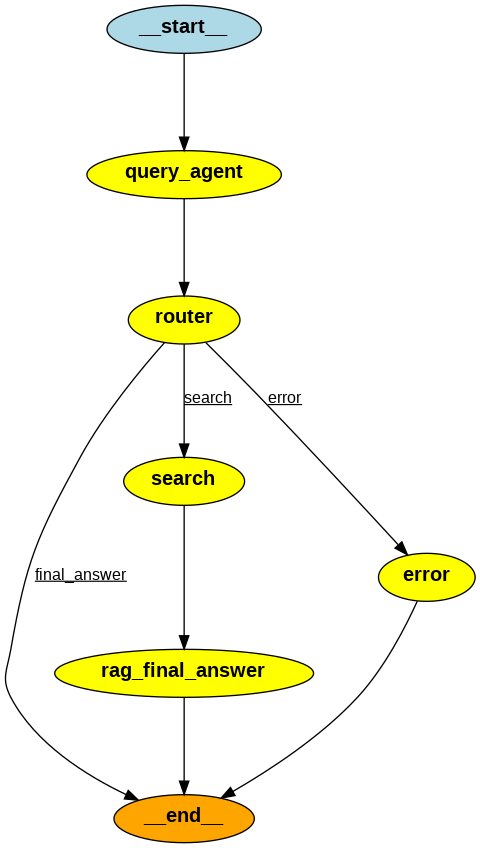

In [ ]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [ ]:
runnable = graph.compile()

out = runnable.invoke({
    "input": "what is AI?",
    "chat_history": []
})

> run_query_agent
> router
> execute_search
> final_answer


In [ ]:
print(out)

{'input': 'what is AI?', 'agent_out': '{"answer":"AI stands for Artificial Intelligence. It refers to the simulation of human intelligence processes by machines, especially computer systems. AI encompasses tasks such as learning, reasoning, problem-solving, perception, and language understanding.","source":"https://en.wikipedia.org/wiki/Artificial_intelligence"}', 'intermediate_steps': [{'search': 'Title: EHI: End-to-end Learning of Hierarchical Index for\nEfficient Dense Retrieval\nSummary: Dense embedding-based retrieval is now the industry\nstandard for semantic search and ranking problems, like obtaining relevant web\ndocuments for a given query. Such techniques use a two-stage process: (a)\ncontrastive learning to train a dual encoder to embed both the query and\ndocuments and (b) approximate nearest neighbor search (ANNS) for finding similar\ndocuments for a given query. These two stages are disjoint; the learned\nembeddings might be ill-suited for the ANNS method and vice-versa,

In [ ]:
print(out["agent_out"])

{"answer":"AI stands for Artificial Intelligence. It refers to the simulation of human intelligence processes by machines, especially computer systems. AI encompasses tasks such as learning, reasoning, problem-solving, perception, and language understanding.","source":"https://en.wikipedia.org/wiki/Artificial_intelligence"}


In [ ]:
runnable = graph.compile()

out = runnable.invoke({
    "input": "아이유는 누구?",
    "chat_history": []
})

> run_query_agent
> router
> execute_search
> final_answer


In [ ]:
print(out)

{'input': '아이유는 누구?', 'agent_out': '{"answer":"아이유는 한국의 가수, 배우, 그리고 작곡가이다.","source":"https://ko.wikipedia.org/wiki/%EC%95%84%EC%9D%B4%EC%9C%A0"}', 'intermediate_steps': [{'search': 'Title: EHI: End-to-end Learning of Hierarchical Index for\nEfficient Dense Retrieval\nSummary: Dense embedding-based retrieval is now the industry\nstandard for semantic search and ranking problems, like obtaining relevant web\ndocuments for a given query. Such techniques use a two-stage process: (a)\ncontrastive learning to train a dual encoder to embed both the query and\ndocuments and (b) approximate nearest neighbor search (ANNS) for finding similar\ndocuments for a given query. These two stages are disjoint; the learned\nembeddings might be ill-suited for the ANNS method and vice-versa, leading to\nsuboptimal performance. In this work, we propose End-to-end Hierarchical\nIndexing -- EHI -- that jointly learns both the embeddings and the ANNS\nstructure to optimize retrieval performance. EHI uses a sta

In [ ]:
out = runnable.invoke({
    "input": "what are EHI embeddings?",
    "chat_history": []
})
print(out["agent_out"])

> run_query_agent
> router
> execute_search
> final_answer
{"answer":"EHI embeddings refer to the embeddings generated by the End-to-end Hierarchical Indexing (EHI) model. These embeddings are learned jointly with the approximate nearest neighbor search (ANNS) structure to optimize retrieval performance. EHI uses a standard dual encoder model to embed queries and documents while learning an inverted file index (IVF) style tree structure for efficient ANNS. The EHI embeddings incorporate dense path embedding to capture the position of a query/document in the tree, ensuring stable and efficient learning of the discrete tree-based ANNS structure.","source":"https://arxiv.org/pdf/2310.08891.pdf"}


In [ ]:
out = runnable.invoke({
    "input": "can you tell me about EHI embeddings?",
    "chat_history": []
})
print(out["agent_out"])

> run_query_agent
> router
> execute_search
> final_answer
{"answer":"EHI embeddings are part of the End-to-end Hierarchical Indexing (EHI) approach that jointly learns both the embeddings and the Approximate Nearest Neighbor Search (ANNS) structure to optimize retrieval performance. EHI uses a standard dual encoder model for embedding queries and documents while learning an inverted file index (IVF) style tree structure for efficient ANNS. To ensure stable and efficient learning of discrete tree-based ANNS structure, EHI introduces the notion of dense path embedding that captures the position of a query/document in the tree.","source":"https://arxiv.org/pdf/2310.08891.pdf"}


In [ ]:
out = runnable.invoke({
    "input": "hi",
    "chat_history": []
})
print(out["agent_out"])

> run_query_agent
> router
> handle_error
{"answer":"Hello! How can I assist you today?","source":"Assistant's response"}


In [ ]:
out = runnable.invoke({
    "input": "hi, 샘알트만은 누구? 출처와 함께 알려줘",
    "chat_history": []
})
print(out["agent_out"])

> run_query_agent
> router
> execute_search
> final_answer
{"answer":"Sam Altman는 OpenAI의 CEO이며, 기술 기업인 OpenAI를 이끄는 중요한 인물 중 하나입니다.","source":"https://www.openai.com/about/"}
